<a href="https://colab.research.google.com/github/shraddha-an/time-series/blob/main/cnn_lstm_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep CNN + LSTM model to predict price movements of securities**
---
## **Project Overview**

**Data**: 5-year historical data of 5 different securities such as,
1. Mini Dow Jones Industrial Average
2. Nikkei Index
3. Gold
4. Bitcoin
5. GBP-USD forex

This project will focus on forecasting the movement direction of the close price of the above 5 stock indices.

Downloaded from [Yahoo Finance](https://finance.yahoo.com/)

**Model**: 

1. Deep CNN layers to extract features from the time-series data

2. LSTM layer that will take in this input and predict the movement of different securities, based on the temporal dependencies in extracted features.

**Acknowledgement**:
This project is based on the research paper, [Deep Learning for Price Movement Prediction Using
Convolutional Neural Network and Long Short-Term Memory](https://downloads.hindawi.com/journals/mpe/2020/2746845.pdf) by Can Yang et.al.

I was particularly interested in developing the CNN module for feature extraction as per the paper.

## **Model Overview**
There are 3 main layers in the model:
1. Input layer
2. CNN module for feature extraction
3. LSTM layer to predict price movement

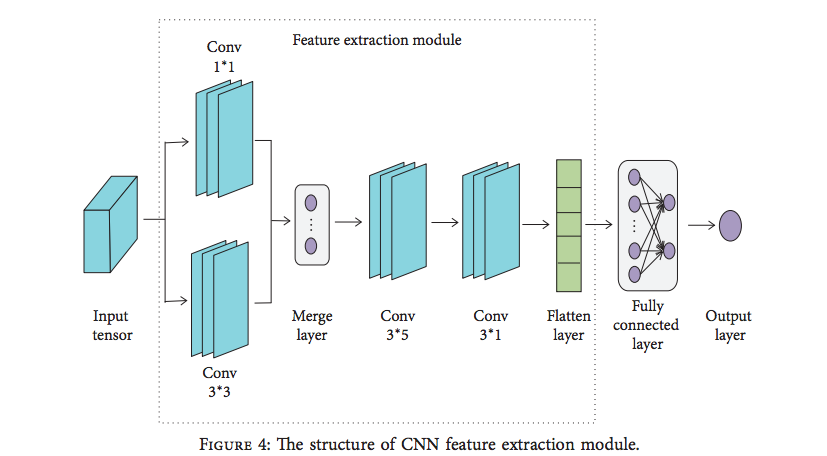


(Image from the paper)


### **Steps:**
---
1) Data Preprocessing - Cleaning up data, Feature Engineering, Preprocessing.

2) Training the model

3) Testing the model

4) Evaluation Metrics

5) EDA + Writing up conclusions

## **Notes on the Stock Indices**
There are 11 stock indices in the paper. Each stock index contains the aggregate information about the various stocks in its collection.

This stock index data is continuous in nature and contains the same features as a normal company's stock data does; open price, close price, high, low etc.

Using Pearson's Correlation formula, linear correlation scores are calculated for each index vs S&P 500. Then the stock indices are arranged, presumably, in the descending order of linear, positive correlation.

This matrix comprises one of the 3 dimensions of the 3-dimensional input tensor.

Setting up the input tensor was a deliberate act to include different sources of information for the CNN to learn.

## **1) Data Preprocessing**

### **1) Importing libraries**

In [ ]:
# Importing libraries
# Data Handling/Manipulation
import pandas as pd, numpy as np

# Time
import time
from datetime import datetime as dt

# Plotting
import matplotlib.pyplot as plt, seaborn as sb

# Zooming plots
'''!pip install mpld3
import mpld3
mpld3.enable_notebook()
'''
# Metrics dict 
metric = {}

In [ ]:
# Importing dataset
url = 'https://query1.finance.yahoo.com/v7/finance/download/%5EDJI?period1=1548979200&period2=1612137600&interval=1d&events=history&includeAdjustedClose=true'
mini_djia = pd.read_csv(url)

# Dropping NaN rows
mini_djia = mini_djia.dropna()
mini_djia.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-02-01,25025.310547,25193.150391,24982.490234,25063.890625,25063.890625,3720900
1,2019-02-04,25062.119141,25239.910156,24977.669922,25239.369141,25239.369141,2985400
2,2019-02-05,25287.929688,25427.320313,25287.650391,25411.519531,25411.519531,3106500
3,2019-02-06,25371.570313,25439.039063,25312.060547,25390.300781,25390.300781,2475900
4,2019-02-07,25265.810547,25314.259766,25000.519531,25169.529297,25169.529297,2954600


### **2) Feature Engineering**
Through feature engineering, I'm going to augment my existing data with new variables. 

```
The purpose of this exercise is to:

1) Improve my domain knowledge 

2) Generate better features for the model to learn.

```

Now coming to my problem, I will have to look for some technical indicators of trades and use my data to generate them. I can then take these indicators and add them to the dataset.

```
Steps - 
1) Decide what features you'd like to retain -> Date, Open, High, Low, Adj Close and Volume
2) Feature engineering options for time-series -> Extract day of the week, week of the year, quarter
3) Choose what indicators/features -> Chosen features + 3 new ones.
4) Code them.



In [ ]:
mini_djia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       503 non-null    object 
 1   Open       503 non-null    float64
 2   High       503 non-null    float64
 3   Low        503 non-null    float64
 4   Close      503 non-null    float64
 5   Adj Close  503 non-null    float64
 6   Volume     503 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
# Feature Engineering

# Step 1: Only retaining Date, Open, High, Low, Adj Close and Volume columns.
mini_djia.drop(columns = ['Close'], inplace = True)

# Step 2: Extracting day of the week, week of the year and quarter info from the Date column
# Converting the Date column to datetime type from object type
mini_djia['Date'] = pd.to_datetime(mini_djia['Date'])

# Day of the week
mini_djia['Day_of_week'] = mini_djia['Date'].dt.dayofweek

# Week of the Year
mini_djia['Week_of_year'] = mini_djia['Date'].dt.weekofyear

# Quarter
mini_djia['Quarter'] = mini_djia['Date'].dt.quarter

# Step 3: Dropping the Date column
mini_djia.drop(columns = ['Date'], inplace = True)
mini_djia.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,Open,High,Low,Adj Close,Volume,Day_of_week,Week_of_year,Quarter
0,25025.310547,25193.150391,24982.490234,25063.890625,3720900,4,5,1
1,25062.119141,25239.910156,24977.669922,25239.369141,2985400,0,6,1
2,25287.929688,25427.320313,25287.650391,25411.519531,3106500,1,6,1
3,25371.570313,25439.039063,25312.060547,25390.300781,2475900,2,6,1
4,25265.810547,25314.259766,25000.519531,25169.529297,2954600,3,6,1


In [ ]:
mini_djia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          503 non-null    float64
 1   High          503 non-null    float64
 2   Low           503 non-null    float64
 3   Adj Close     503 non-null    float64
 4   Volume        503 non-null    int64  
 5   Day_of_week   503 non-null    int64  
 6   Week_of_year  503 non-null    int64  
 7   Quarter       503 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 35.4 KB


In [ ]:
# Splitting the dataset into feature matrix, X & target matrix, y
X = mini_djia.iloc[:, 1:].values
y = mini_djia.iloc[:, 0].values.reshape(-1, 1)

# Splitting into train & test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
X_train[98]

array([2.60292109e+04, 2.58965605e+04, 2.59160000e+04, 3.38520000e+06,
       3.00000000e+00, 9.00000000e+00, 1.00000000e+00])

### **3) Preprocessing - Scaling & Encoding**

In [ ]:
'''# One Hot Encoding the 'Quarter' column
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


ct = ColumnTransformer(transformers = ['one_hot_encode', OneHotEncoder(), [6]])

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

X_test[34]'''

"# One Hot Encoding the 'Quarter' column\nfrom sklearn.preprocessing import LabelEncoder, OneHotEncoder\nfrom sklearn.compose import ColumnTransformer\n\n\nct = ColumnTransformer(transformers = ['one_hot_encode', OneHotEncoder(), [6]])\n\nX_train = ct.fit_transform(X_train)\nX_test = ct.transform(X_test)\n\nX_test[34]"

In [ ]:
# Scaling - Standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_test[34]

array([ 0.41956767,  0.50184396,  0.47869088, -1.02082499,  1.41604676,
        1.34487175,  1.33591706])

## **3) Creating 3D dataset**

### **Tasks**


*   Create deterministic trend signals from technical indicators
*   Figure out how to include stock indices data

* Calculate correlations b/ S&P 500 and other indices.

* Fit it in as a dimension.



In [ ]:
# Creating technical indicators for stock prices
# 1) Simple Moving Average: SMA(t) = ∑ Price / n; n -> number of days considered.



## **4) Training**

### **1) Baseline - Linear Regression**

In [ ]:
# Baseline model: Linear Regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions on test set
y_preds = lin_reg.predict(X_test)

# Evaluating MSE & MAE metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_preds)
mae = mean_absolute_error(y_test, y_preds)

metric['Linear Regression model'] = {'mse': mse, 'mae': mae}
metric

{'Linear Regression model': {'mae': 88.67564960394816,
  'mse': 12273.378431408382}}

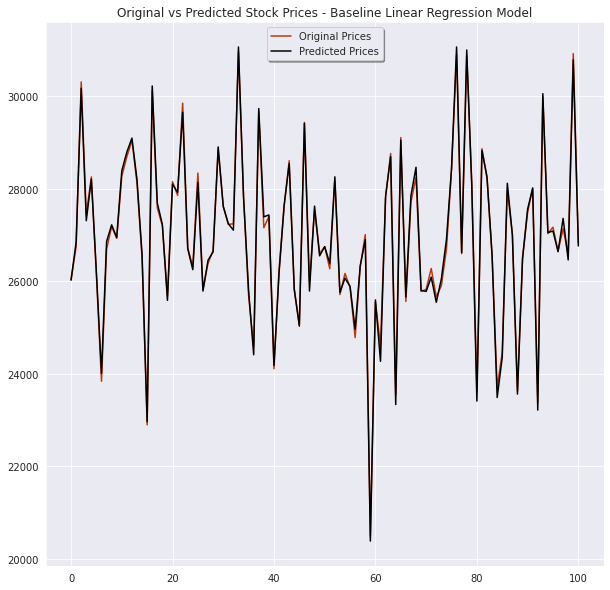

In [ ]:
# Plotting how close the predicted values are to the original values
sb.set_style('darkgrid')
plt.figure(figsize = (10, 10))

plt.plot(y_test, label = 'Original Prices', color = '#BF360C')
plt.plot(y_preds, label = 'Predicted Prices', color = 'black')

plt.title('Original vs Predicted Stock Prices - Baseline Linear Regression Model')
plt.legend(shadow = "True", loc = 'upper center')
plt.show()

### **2) CNN + LSTM**

Steps:

1) Build Keras model

2) Define layer architecture in TF

3) Write training/testing loops for TF

4) Defing layer architcture in PyTorch

5) Repeat 3) for PyTorch

### **1) Keras Model**

In [ ]:
X_train.shape[1], y_train[0]

(7, array([29440.470703]))

In [ ]:
# Resizing Input X_train to be 3-D instead of 2-D as that's how Conv1D layer expects (batch_size, steps, features)
X_Train = np.resize(X_train, new_shape = (X_train.shape + (1,)))
X_Test = np.resize(X_test, new_shape = (X_test.shape + (1,)))

X_Train.shape, X_Test.shape, y_train.shape, y_test.shape

((402, 7, 1), (101, 7, 1), (402, 1), (101, 1))

In [ ]:
# Building separate Conv layers for the parallel conv branches via the functional API
# Importing Keras modules
from keras.models import Sequential, Model
from keras.layers import Conv1D, Concatenate, LSTM, Flatten, Dense, Input, concatenate

# Subclassing the Model class
class RegressionModel(Model):
  # Defining layer architecture in the constructor
  def __init__(self):
    # Calling the parent constructors in the correct MRO
    super().__init__()
    # Defining layers in the model
    self.a = Conv1D(filters = 10, kernel_size = (1, ), padding = 'same')
    self.b = Conv1D(filters = 10, kernel_size = (3, ), padding = 'same')
    
    #self.merged = Concatenate(axis = 0)([self.a, self.b])

    self.c = Conv1D(filters = 10, kernel_size = (3, ), padding = 'same')
    self.d = Conv1D(filters = 10, kernel_size = (3, ), padding = 'same')
    self.flat = Flatten()
    self.e = Dense(units = 10)
    self.f = Dense(units = 1)

  # Defining the forward pass computations in the call method
  def call(self, input_x):
    # Pass input through the 1st Convolutional layer in the parallel convolution branch
    c1 = self.a(input_x)

    # Pass input through the 2nd Convolutional layer in the parallel convolution branch
    c2 = self.b(input_x)

    # Concatenate output tensors of the 2 convolutional layers
    x = concatenate(inputs = [c1, c2], axis = 2) # Merge columns, keep batch_size & rows the same
    
    # Pass previous output through the rest of the layers
    x = self.c(x)
    x = self.d(x)
    x = self.flat(x)
    x = self.e(x)
    x = self.f(x)

    return x

# Creating an object of RegressionModel
model = RegressionModel()

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

# Fitting the model on training data
model.fit(X_Train, y_train, epochs = 100, batch_size = 5, verbose = 2)


Epoch 1/100
81/81 - 1s - loss: 26878.2520
Epoch 2/100
81/81 - 0s - loss: 26164.5723
Epoch 3/100
81/81 - 0s - loss: 12532.3721
Epoch 4/100
81/81 - 0s - loss: 923.6514
Epoch 5/100
81/81 - 0s - loss: 685.5641
Epoch 6/100
81/81 - 0s - loss: 556.6215
Epoch 7/100
81/81 - 0s - loss: 493.6972
Epoch 8/100
81/81 - 0s - loss: 477.9324
Epoch 9/100
81/81 - 0s - loss: 455.7192
Epoch 10/100
81/81 - 0s - loss: 419.8371
Epoch 11/100
81/81 - 0s - loss: 426.5585
Epoch 12/100
81/81 - 0s - loss: 406.9794
Epoch 13/100
81/81 - 0s - loss: 393.2953
Epoch 14/100
81/81 - 0s - loss: 353.0635
Epoch 15/100
81/81 - 0s - loss: 323.3809
Epoch 16/100
81/81 - 0s - loss: 308.1115
Epoch 17/100
81/81 - 0s - loss: 327.8655
Epoch 18/100
81/81 - 0s - loss: 290.6957
Epoch 19/100
81/81 - 0s - loss: 280.7858
Epoch 20/100
81/81 - 0s - loss: 286.4749
Epoch 21/100
81/81 - 0s - loss: 235.3817
Epoch 22/100
81/81 - 0s - loss: 219.5274
Epoch 23/100
81/81 - 0s - loss: 220.8808
Epoch 24/100
81/81 - 0s - loss: 209.3949
Epoch 25/100
81/81 

In [ ]:
# Predicting on test set
y_pred = model.predict(X_Test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

metric['Deep CNN model'] = {'mse': mse, 'mae': mae}
metric

{'Deep CNN model': {'mae': 188.8662980222774, 'mse': 62341.91634448324},
 'Linear Regression model': {'mae': 88.67564960394816,
  'mse': 12273.378431408382}}

In [ ]:
X_Train.shape

(402, 7, 1)

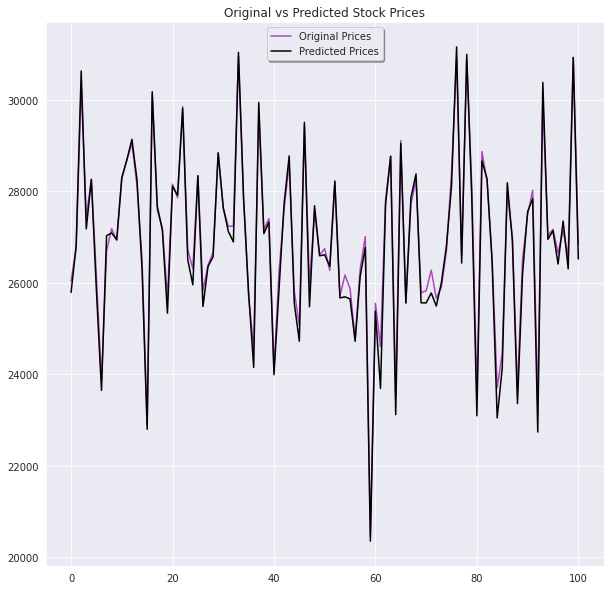

In [ ]:
# Plotting how close the predicted values are to the original values
sb.set_style('darkgrid')
plt.figure(figsize = (10, 10))

plt.plot(y_test, label = 'Original Prices', color = '#AB47BC')
plt.plot(y_pred, label = 'Predicted Prices', color = 'black')

plt.title('Original vs Predicted Stock Prices')
plt.legend(shadow = "True", loc = 'upper center')
plt.show()